# Chatbot with LangGraph 

## Set up Groq and Tavily

In [1]:
import getpass
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [2]:
# Set up Groq, the LLM
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

In [3]:
# Set up Tavily, the search engine
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter API key for Tavily: ")

## Set up LLM with tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(max_results=2)
tools = [search]

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [6]:
# tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

## LangGraph

In [7]:
# Incorporate it into a StateGraph
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# The class is a dict to store messages returned by llm
# The key "messages" has a value of list
# The update rule of "messages" value is appending the list instead of overwritting it
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [8]:
# Create a function to run the tools
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        # dict of tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # get the most recent message in the state dict
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        # calls tools if the message contains tool_calls
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[search])
graph_builder.add_node("tools", tool_node)

In [9]:
# Define the conditional_edges
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# MemorySaver helps remember chat history
# Use SqliteSaver or PostgresSaver and connect a database for persistent store. 
memory = MemorySaver() # In-Memory Saver, for demo only
graph = graph_builder.compile(checkpointer=memory)

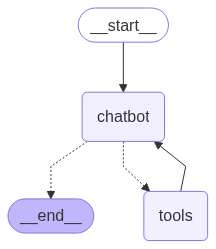

In [10]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
# Change thread_id for different conversation
config = {"configurable": {"thread_id": "2"}}

In [12]:
# Set up system message, set None to disable
system_message = 'Whenever you do not know the answer or need up-to-date information, perform a web search to find accurate and relevant results before responding.'

In [13]:
def stream_graph_updates(user_input: str):
    if system_message:        
        messages = [{"role": "system", "content": system_message}, {"role": "user", "content": user_input}]
    else:
        messages = [{"role": "user", "content": user_input}]
    events = graph.stream(
    {"messages": messages},
    config,
    stream_mode="values",)
    for event in events:
        event["messages"][-1].pretty_print()

In [14]:
# Ask the bot questions
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

User:  Hello


================================ Human Message =================================

Hello
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_qddk)
 Call ID: call_qddk
  Args:
    query: Hello
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Hello (Adele song) - Wikipedia", "url": "https://en.wikipedia.org/wiki/Hello_(Adele_song)", "content": "\"Hello\" is a song recorded by British singer-songwriter Adele, released on 23 October 2015 by XL Recordings as the lead single from her third studio album, 25 (2015). Written by Adele and the album's producer, Greg Kurstin, \"Hello\" is a piano ballad with soul influences (including guitar) and lyrics that discuss themes of nostalgia and regret. Upon release, the song garnered critical acclaim, with reviewers comparing it favourably to Adele's previous works and praised its lyrics, production an

User:  q


Goodbye!


The chatbot remember the city and search the web successfully.

In [15]:
# Get the state of the checkbot for eval
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [SystemMessage(content='Whenever you do not know the answer or need up-to-date information, perform a web search to find accurate and relevant results before responding.', additional_kwargs={}, response_metadata={}, id='c1d59c3e-5280-4b82-b56c-8cff24109835'), HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='e256f544-5880-4828-85f5-86bad9fbe003'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qddk', 'function': {'arguments': '{"query":"Hello"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 944, 'total_tokens': 1021, 'completion_time': 0.057002703, 'prompt_time': 0.116441991, 'queue_time': 0.12910957, 'total_time': 0.173444694}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_f974fb141b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a0fc10c5-4bc8-4577-9d51-004b6779d703-0', tool_calls=[{'